In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from tqdm import tqdm
from scipy.linalg import eigh
import scipy
import scipy.stats
import optim
from importlib import reload
reload(optim)
from optim import *
from utils import *

import matplotlib
matplotlib.rcParams['text.usetex'] = True
#tqdm=aux

Base coefficient generators yield parameters as in:

$$
P_{t+1}(\lambda)=a_tP_t(\lambda)+b_t\lambda P_t(\lambda)+c_tP_{t-1}(\lambda)
$$

Let $\xi$ be a linear map between the domains, i.e. $\xi:[0,L]\rightarrow[-1,1]=ax+b=\frac{L}{2}(x+1)$. Then if $P_t(x)=\tilde{P}_t(x)$, it's recurrence coefficients follow:  
$a_t=\tilde{a}_t+b\tilde{b}_t$ $b_t=a\tilde{b}_t$





## MP distribution

In [ ]:
## jacobi stability

beta_list=[5/2,7/2,10]
methods,tags=[nesterov]+[jm_decorator(1/2,l) for l in beta_list],['nesterov']+[r'Chebyshev $\alpha=$'+str(l) for l in beta_list]
logs=[[] for _ in range(len(methods))]
for _ in range(10):
    for m,l in zip(methods,logs):
        f= RandomQuadratic()
        l.append(m(f,niter=600)[0].to_numpy()[0])
logs=[np.stack(l) for l in logs]

In [ ]:
for log_idx in [0,2]:

    plt.figure(dpi=100)

    for a, tag in zip(logs,tags):
        #a=np.log10(a)1
        a=a[:,:,:2000]
        m,std=a.mean(0),a.std(0)
        plt.fill_between(np.arange(a.shape[-1]),np.maximum((m-std)[log_idx],0.1*m[log_idx]),(m+std)[log_idx],alpha=0.2,label=tag)
        #plt.fill_between(np.arange(len(m[log_idx])),a.min(0)[log_idx],a.max(0)[log_idx],alpha=0.2)

        #plt.plot(m[log_idx]*(np.linspace(0,2000,2000)**(3 if log_idx==0 else 5)),label=tag)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid()
    plt.legend()

In [ ]:
import sklearn
begin_idx=100
for  l in logs:
    plt.figure(dpi=50)
    for log_idx in [0,2]:
        m=l[:,log_idx,begin_idx:].mean(0)
        model=sklearn.linear_model.LinearRegression()
        logx=np.log(np.arange(begin_idx,601).astype(float))
        model.fit(logx[:,None],np.log(m)[:,None])
        plt.plot(np.exp(logx),np.exp(model.predict(logx[:,None])))
        plt.plot(np.exp(logx),m)
        plt.xscale('log')
        plt.yscale('log')
        print(model.coef_)


##The slope is now what we expected
##

In [95]:


methods,tags=[jm_decorator(1/2,3/2),jm_decorator(1/2,5/2),cg,gd,nesterov],[r'Chebyshev $\beta=\frac{3}{2}$',r'Chebyshev $\beta=\frac{5}{2}$',
                                                                                             'cg','gd','nesterov']
tags=[r'GCM$(\frac{1}{2},\frac{3}{2})$',r'GCM$(\frac{1}{2},\frac{5}{2})$','CG','GD','Nesterov']
logs=[[] for _ in range(len(methods))]
for _ in range(8):
    for m,l in zip(methods,logs):
        f= RandomQuadratic(r=1,n=1000)
        l.append(m(f,niter=600)[0].to_numpy()[0])
logs=[np.stack(l) for l in logs]


C:\Users\leona\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


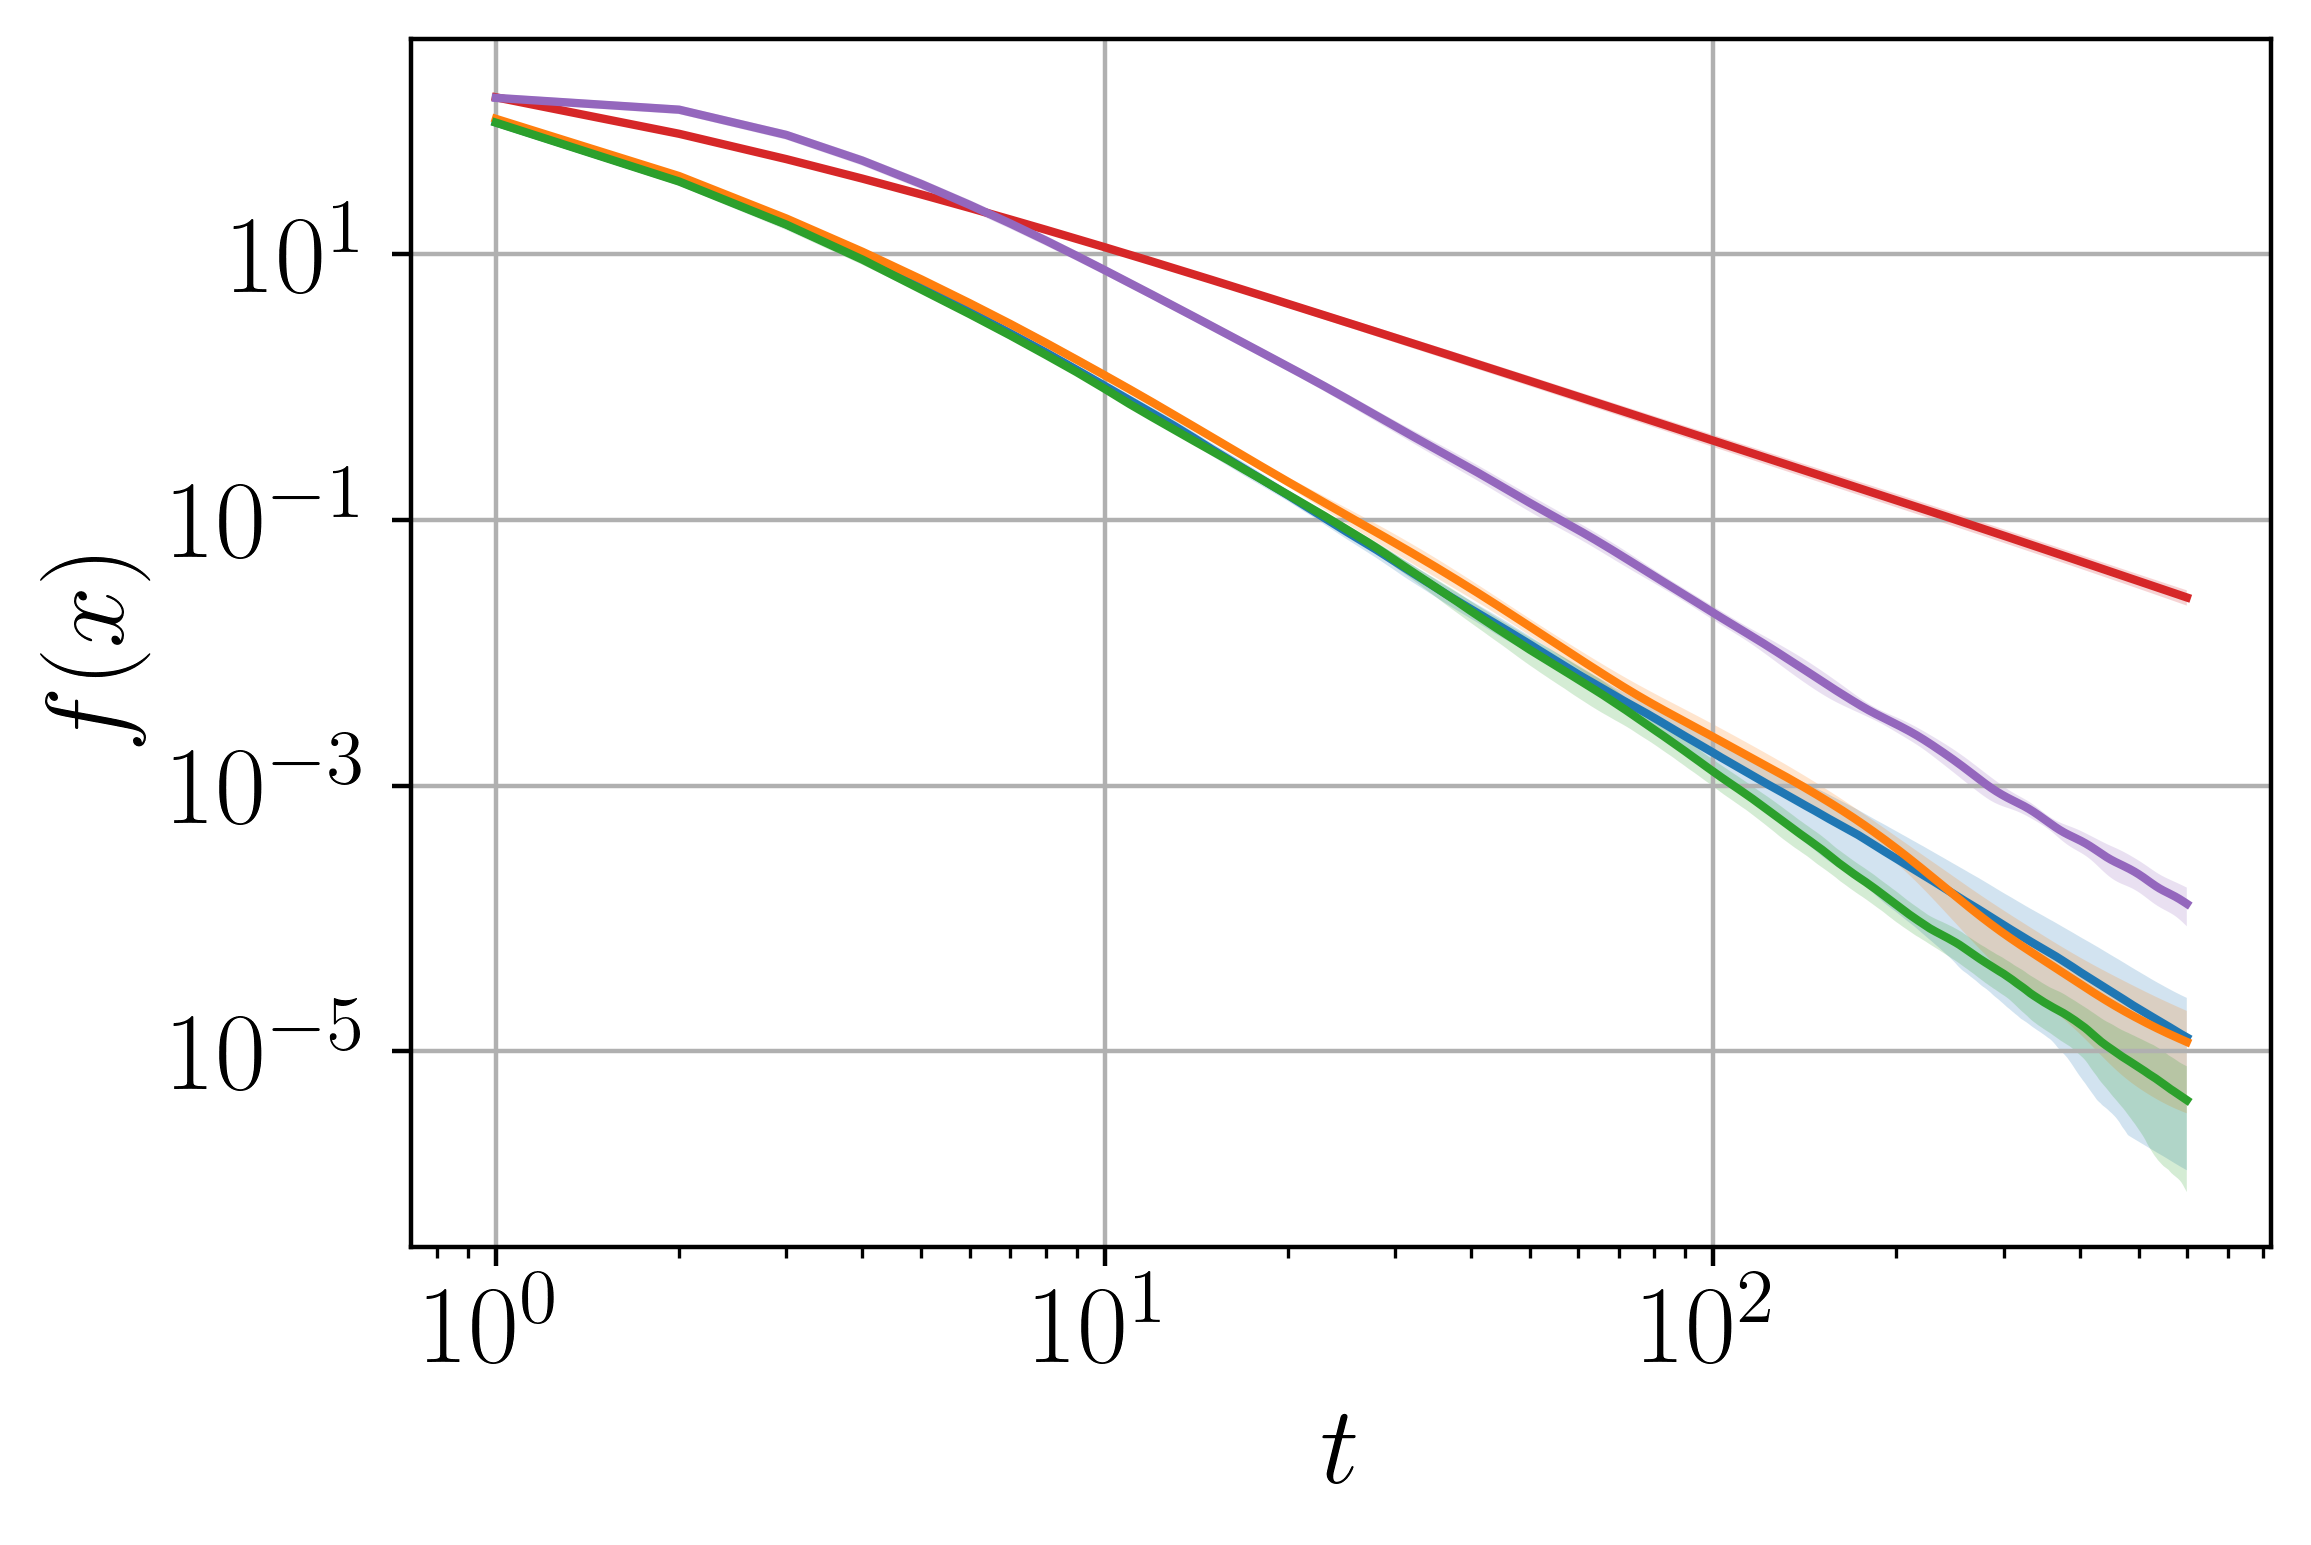

In [99]:
matplotlib.rcParams.update({'font.size': 20})

log_idx=2
plt.figure(dpi=400)

for a, tag in zip(logs,tags):
    #a=np.log10(a)1
    a=a[:,:,1:]
    m,std=a.mean(0),a.std(0)
    plt.fill_between(np.arange(1,a.shape[-1]+1),np.maximum((m-std)[log_idx],0.1*m[log_idx]),(m+std)[log_idx],alpha=0.2)
    #plt.fill_between(np.arange(len(m[log_idx])),a.min(0)[log_idx],a.max(0)[log_idx],alpha=0.2)

    plt.plot(np.arange(1,a.shape[-1]+1),m[log_idx],label=tag)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel(r'$f(x)$')
#plt.ylabel(r'$||\nabla f(x)||^2$')
plt.xlabel(r'$t$')
#plt.legend(prop={'size': 13})
plt.savefig('new_imgs/mp_f.pdf',bbox_inches='tight')



## Fat tails


The jacobi method, $a=1,2$ has shown very good performance on distributions with increasingly fat tails, gamma distributions

## Inception + MNIST Features

In [84]:
from torchvision.datasets import MNIST
import torchvision
dataset=MNIST('data',download=True,transform=torchvision.transforms.ToTensor())

train_data=np.stack([dataset[i][0].view(-1).numpy() for i in range(len(dataset))])
train_y=np.array([dataset[i][1] for i in range(len(dataset))])


In [90]:

import torch
train_y=torch.load('data/labels_cifar_train')
train_data=torch.load('data/cifar_train')

In [91]:
import numpy as np
N=8000
perm=np.random.permutation(np.arange(len(train_data)))
sample=train_data[perm[:N]]
train_y=train_y[perm[:N]]
nsample=(sample-sample.mean(0))/sample.std()
_,evs,_=np.linalg.svd(nsample)

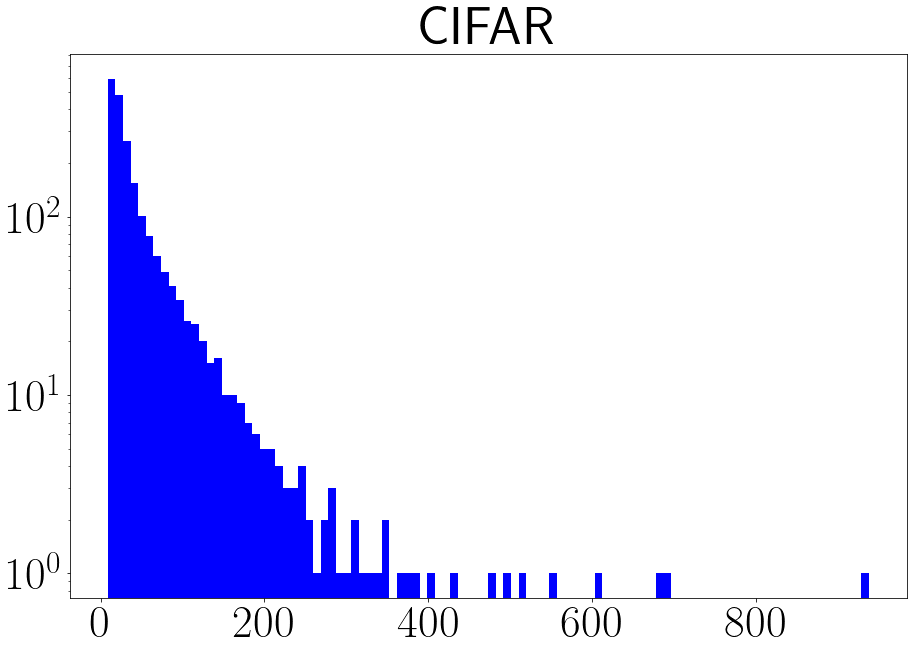

In [52]:
matplotlib.rcParams.update({'font.size': 45})
plt.figure(figsize=(15,10))


plt.hist(evs,bins=100,color='b')
#_,evs,_=np.linalg.svd(sample)
#plt.hist(evs[evs<100],bins=100,color='r')
plt.yscale('log')
plt.title('CIFAR')
plt.savefig('new_imgs/cifar_spectrum.pdf')

In [92]:
methods,tags=[jm_decorator(1/2,3/2),jm_decorator(1/2,5/2),cg,gd,nesterov,],[r'Chebyshev $\beta=\frac{3}{2}$',r'Chebyshev $\beta=\frac{5}{2}$',
                                                                                             'cg','gd','nesterov']
logs=[[] for _ in range(len(methods))]
for _ in range(4):
    for m,l in zip(methods,logs):
        f= FeaturesQuadratic(nsample,train_y)
        l.append(m(f,L=f.L,niter=600)[0].to_numpy()[0])
logs=[np.stack(l) for l in logs]


C:\Users\leona\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


GCM$(\frac{1}{2},\frac{3}{2})$
[[-2.59655299]]
[[-2.86030917]]
[[-2.90264752]]
[[-3.21333995]]
Mean: -2.893
GCM$(\frac{1}{2},\frac{5}{2})$
[[-4.94303986]]
[[-4.93892391]]
[[-4.94428855]]
[[-4.94948379]]
Mean: -4.944
CG
[[-13.59495576]]
[[-13.61521701]]
[[-13.58626882]]
[[-13.5961747]]
Mean: -13.598
GD
[[-1.11494349]]
[[-1.11580386]]
[[-1.11116999]]
[[-1.1056258]]
Mean: -1.112
Nesterov
[[-2.98039175]]
[[-2.98737518]]
[[-2.97890104]]
[[-2.98090391]]
Mean: -2.982


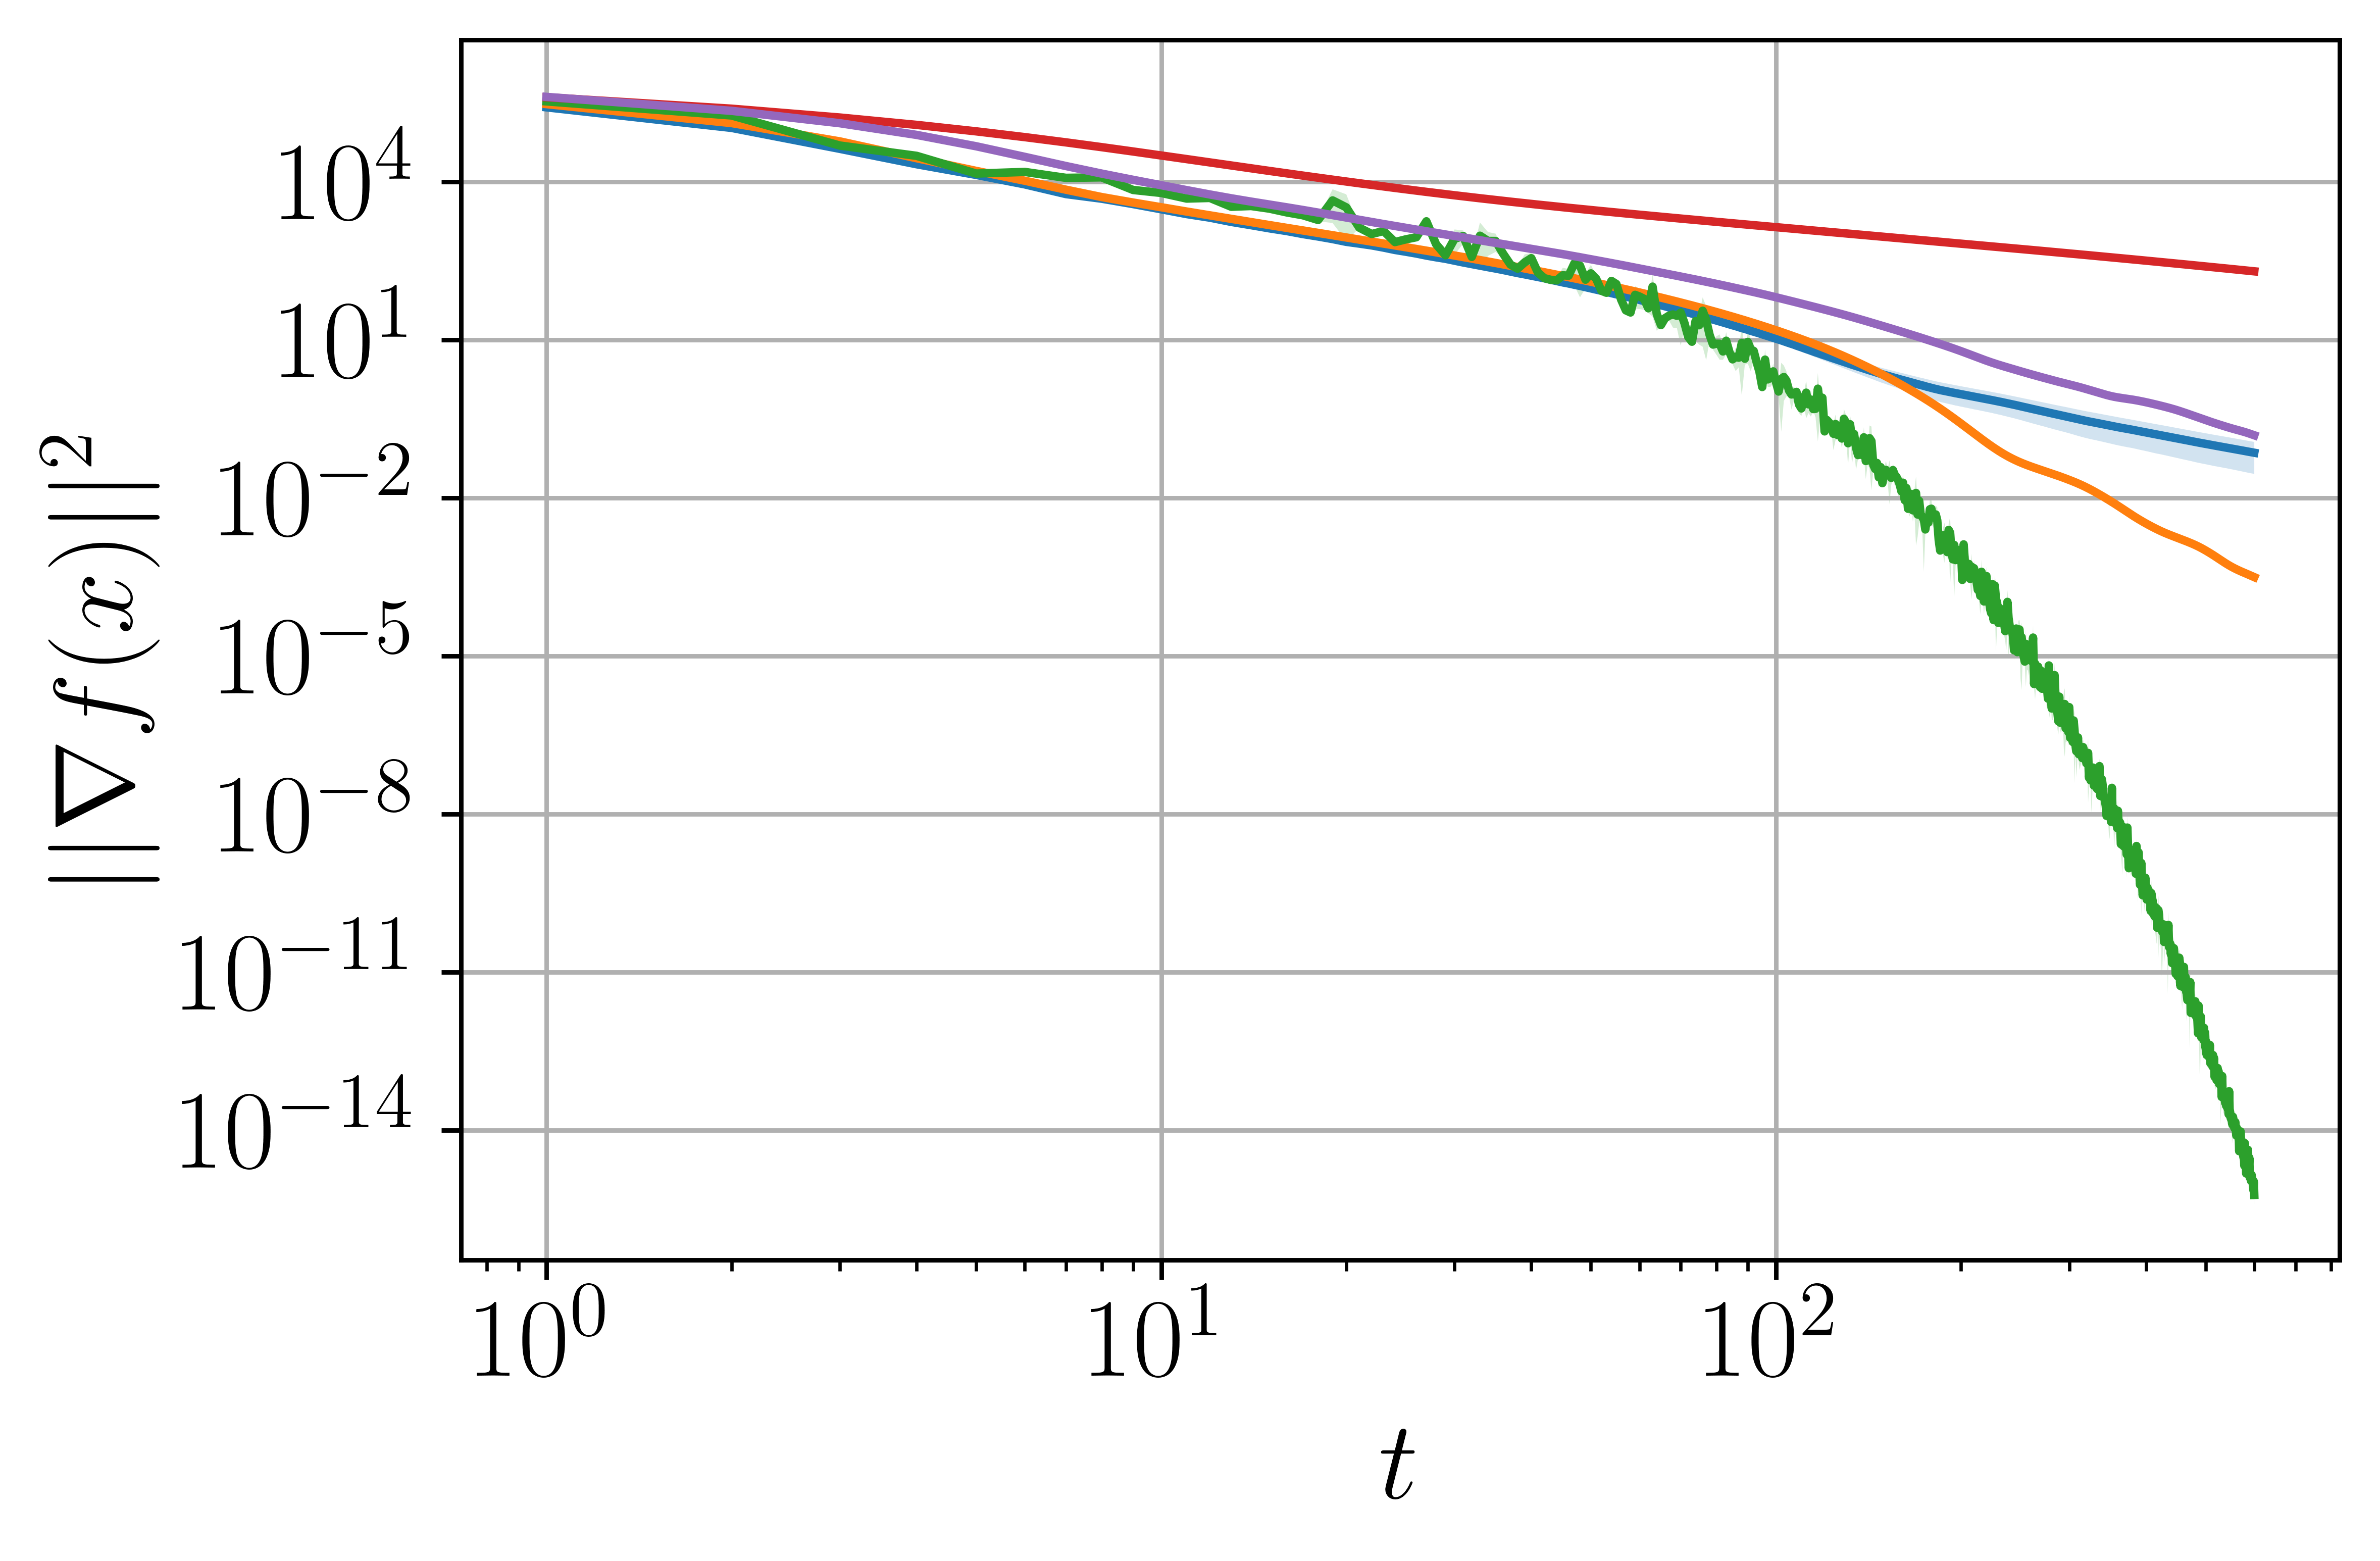

In [94]:
from sklearn.linear_model import LinearRegression
tags=[r'GCM$(\frac{1}{2},\frac{3}{2})$',r'GCM$(\frac{1}{2},\frac{5}{2})$','CG','GD','Nesterov']
begin_idx=10
matplotlib.rcParams.update({'font.size': 20})

for log_idx in [0]:

    plt.figure(dpi=800)
    
    for a, tag in zip(logs,tags):
        #if tag=='cg': continue
        #a=a-a[:,:,-1][:,:,None]
        logx=np.log(np.arange(begin_idx,601).astype(float))
        print(tag)
        all_c=[]
        for aux in a:
                model=LinearRegression()
                model.fit(logx[:,None],np.log(aux[log_idx][begin_idx:,None]))
                plt.xscale('log')
                plt.yscale('log')
                print(model.coef_)
                all_c.append(float(model.coef_))
        print('Mean: %.3f'% np.asarray(all_c).mean())
        m,std=a.mean(0),a.std(0)
        plt.fill_between(np.arange(1,m.shape[-1]),np.maximum((m-std)[log_idx],0.1*m[log_idx])[1:],(m+std)[log_idx,1:],alpha=0.2)
        #plt.fill_between(np.arange(len(m[log_idx])),a.min(0)[log_idx],a.max(0)[log_idx],alpha=0.2)

        plt.plot(np.arange(1,m.shape[-1]),m[log_idx,1:],label=tag)
    plt.yscale('log')
    plt.ylabel(r'$||\nabla f(x)||^2$')
    plt.xlabel(r'$t$')
    plt.xscale('log')
    plt.yticks(10**np.arange(-14,5,3).astype(float))
    #plt.yticks(10**np.arange(-2,5,2).astype(float))
    #plt.legend(loc='lower left',prop={'size': 12})
    plt.grid()
    plt.savefig('new_imgs/cifar.pdf',bbox_inches='tight')
        
